In [34]:
import pandas as pd
from read_data import read_data
import numpy as np

def compute_delta_metrics(data):
    """
    Computes additional metrics for the dataset:
    - Delta Position: Leader's position minus Follower's position.
    - Delta Velocity: Leader's velocity minus Follower's velocity.
    - Delta Acceleration: Leader's acceleration minus Follower's acceleration.
    - Time-To-Collision (TTC): Delta Position divided by Delta Velocity.
    """
    data["delta_position"] = data["x_leader"] - data["x_follower"]
    data["delta_velocity"] = data["v_follower"] - data["v_leader"]
    data["delta_acceleration"] = data["a_follower"] - data["a_leader"]
    data["TTC"] = data["delta_position"] / data["delta_velocity"]
    data.loc[data["TTC"] < 0, "TTC"] = np.nan
    data['time_headway'] = data['delta_position'] / data['v_follower']
    data['TTC_min'] = data['TTC']

    # Calculate jerk for the follower vehicle
    data['jerk_follower'] = np.gradient(data['a_follower'], data['time'])
    return data

def aggregate_data_by_case(data):
    """
    Aggregates the dataset by 'case_id' to find the max and min 
    of each delta metric and TTC for each case.
    Renames columns for clarity and adds case_id as a column.
    """
    aggr_data = data.groupby('case_id').agg({'delta_velocity':'mean',
                           'v_follower':'max',
                           'delta_acceleration':'mean',
                           'a_follower':'max',
                           'jerk_follower':'mean',
                           'time_headway':'median',
                           'delta_position':'min',
                           'TTC':'median',
                           'TTC_min':'min'}).reset_index()

    return aggr_data

def adjust_ttc_sign(aggregated_data):
    """
    Ensures TTC (Time-To-Collision) is non-negative by taking the absolute value.
    """
    aggregated_data["TTC"] = aggregated_data["TTC"].abs()
    aggregated_data["TTC_min"] = aggregated_data["TTC_min"].abs()
    return aggregated_data

def convert_df(dataset: str, mode: str):
    """
    Main function that utilizes the above helper functions to preprocess the data.
    Returns a DataFrame grouped by 'case_id' with max and min values of
    delta position, delta velocity, delta acceleration, and TTC (Time-To-Collision).
    """
    data = read_data(dataset, mode)
    data = compute_delta_metrics(data)
    aggregated_data = aggregate_data_by_case(data)
    aggregated_data = adjust_ttc_sign(aggregated_data)
    return aggregated_data



In [35]:
# trainHA = convert_df("HA", "train")
# trainHA.head(500)

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants for settings that may change
RANDOM_STATE = 42
PCA_COMPONENTS = 2


def preprocess_features(features):
    """Normalize the features of a dataframe."""
    scaler = StandardScaler()
    features_numeric = features.select_dtypes(include=np.number).dropna()
    normalized_data = scaler.fit_transform(features_numeric)
    return normalized_data, features_numeric


def apply_dimensionality_reduction(data, n_components=PCA_COMPONENTS):
    """Apply PCA to reduce dimensions of the data."""
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)


def perform_clustering(data, n_clusters):
    """Perform KMeans clustering on the data."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(data)
    return labels


def plot_clusters(features, labels, pca_data=None):
    """Plot the results of clustering."""
    if pca_data is not None:
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap="viridis")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("K-Means Clustering with PCA")
    else:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_subplot(121, projection="3d")
        ax.scatter(
            features.iloc[:, 0],
            features.iloc[:, 1],
            features.iloc[:, 2],
            c=labels,
            cmap="viridis",
            s=50,
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Feature 3")
        ax.set_title("K-Means Clustering Results")
    plt.show()


def find_optimal_clusters(data, max_clusters=10):
    """Determine the optimal cluster count using silhouette score and elbow method."""
    inertia_list = []
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
        labels = kmeans.fit_predict(data)
        inertia_list.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))

    # Elbow Method Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), inertia_list, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")

    # Silhouette Score Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Scores for Various Clusters")
    plt.tight_layout()
    plt.show()

    # Assuming the elbow is at the cluster number with the highest silhouette score
    optimal_clusters = (
        np.argmax(silhouette_scores) + 2
    )  # +2 because range starts from 2
    return optimal_clusters


def get_clustered_df(features):
    """Main function to execute the clustering analysis pipeline."""
    # Load and preprocess the data

    normalized_data, features_numeric = preprocess_features(features)

    # Optionally apply PCA
    pca_data = apply_dimensionality_reduction(normalized_data)

    # Find the optimal number of clusters
    optimal_clusters = find_optimal_clusters(pca_data)

    # Perform clustering with the optimal number of clusters
    labels = perform_clustering(pca_data, optimal_clusters)
    features_numeric["cluster"] = labels

    # Plot the results
    plot_clusters(features_numeric, labels, pca_data)

    # Compute and display the average silhouette score
    silhouette_avg = silhouette_score(pca_data, labels)
    print(f"The average silhouette_score is: {silhouette_avg}")

    return features_numeric

# clustered_data = get_clustered_df(trainHA)

In [37]:
def train_df(dataset: str, clustered_data: pd.DataFrame, mode: str):
    """
    Returns a DataFrame with delta position, delta velocity, v_follower and cluster.
    """
    data = read_data(dataset, mode)
    data = compute_delta_metrics(data)
    # print(data.head())
    # print(clustered_data.head())
    
    # Merge the data with clustered_data on 'case_id' to get the 'cluster' column
    data = pd.merge(data, clustered_data[['case_id', 'cluster']], on='case_id', how='left')
    data = data[["delta_position", "delta_velocity", "v_follower","cluster"]]
    print(data.head())
    return data


# train_data = train_data("HA", clustered_data, "train")


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import math
from torch.utils.data import DataLoader, TensorDataset



class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        outputs, (hx, cx) = self.lstm(x)
        return hx[-1], cx[-1]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        predictions = self.linear(outputs)
        return predictions, hidden[-1], cell[-1]

class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_steps_out):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
        self.n_steps_out = n_steps_out

    def forward(self, x):
        hidden, cell = self.encoder(x)
        # 初始化解码器的输入
        decoder_input = torch.zeros((x.size(0), self.n_steps_out, self.decoder.lstm.input_size)).to(x.device)
        outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        return outputs


def preprocess_data(df, n_steps_in=30, n_steps_out=10, test_size=0.2):
    # 只保留需要的列
    df = df[["delta_position", "delta_velocity", "v_follower"]]
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(df)
    X, y = create_sequences(data_normalized, n_steps_in, n_steps_out)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return (
        torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32),
        scaler
    )


def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(0, len(data) - n_steps_in - n_steps_out + 5):
        seq_x = data[i:i + n_steps_in]
        seq_y = data[i + n_steps_in:i + n_steps_in + n_steps_out]
        if seq_x.shape[0] == n_steps_in and seq_y.shape[0] == n_steps_out:
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)


# def train_model(model, X_train_tensor, y_train_tensor, epochs, optimizer, loss_function):
#     for epoch in tqdm(range(epochs), desc='Training Epochs'):
#         model.train()
#         optimizer.zero_grad()
#         y_pred = model(X_train_tensor)
#         loss = loss_function(y_pred, y_train_tensor)
#         loss.backward()
#         optimizer.step()
#         if epoch % 10 == 0:
#             tqdm.write(f'Epoch: {epoch} Loss: {loss.item():.4f}')


def evaluate_model(model, X_test_tensor, y_test_tensor, scaler, device):
    # Move the model to the specified device
    model = model.to(device)
    
    # Move the tensors to the same device as the model
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        # Move the predictions back to CPU for further numpy operations
        y_pred_numpy = y_pred.cpu().numpy()
        
        y_pred_original = np.zeros_like(y_pred_numpy)
        y_test_numpy = y_test_tensor.cpu().numpy()
        
        for i in range(y_pred_numpy.shape[1]):
            y_pred_original[:, i, :] = scaler.inverse_transform(y_pred_numpy[:, i, :])

        y_test_original = np.zeros_like(y_test_numpy)
        for i in range(y_test_numpy.shape[1]):
            y_test_original[:, i, :] = scaler.inverse_transform(y_test_numpy[:, i, :])

        mse = mean_squared_error(y_test_original[:, 0, :], y_pred_original[:, 0, :])
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test_original[:, 0, :], y_pred_original[:, 0, :])
        print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')
        



def train_model(model, dataloader, epochs, optimizer, loss_function, device="cuda", accumulation_steps=4):
    model.to(device)  # Ensure model is on the correct device
    for epoch in tqdm(range(epochs), desc='Training Epochs'):
        model.train()
        optimizer.zero_grad()  # Reset gradients tensors
        for i, (X_batch, y_batch) in enumerate(dataloader):
            print(f"Batch {i} - X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")  # Debugging line
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move batch data to the device

            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch) / accumulation_steps  # Normalize our loss

            loss.backward()
            if (i + 1) % accumulation_steps == 0 or i + 1 == len(dataloader):
                optimizer.step()  # Perform a single optimization step
                optimizer.zero_grad()  # Reset gradients tensors

            # Clear some memory
            del X_batch, y_batch, y_pred
            gc.collect()  # Force garbage collection
            if device == 'cuda':
                torch.cuda.empty_cache()  # Clear cache if on GPU

        if epoch % 10 == 0:
            tqdm.write(f'Epoch: {epoch} Loss: {loss.item() * accumulation_steps:.4f}')  # Adjust the loss value



def run_training(train_data,dataset, n_steps_in=30, n_steps_out=10, epochs=1, lr=0.01, device="cuda" ):
    clustered_dataframes = {}
    for cluster_number in train_data["cluster"].unique():
        clustered_dataframes[cluster_number] = train_data[train_data["cluster"] == cluster_number]
    print("cluster is over")
    models_scalers = {}
    for cluster, cluster_df in clustered_dataframes.items():
        if cluster_df.empty:
            print(f"Cluster {cluster} is empty.")
            continue

        (
            X_train_tensor,
            y_train_tensor,
            X_test_tensor,
            y_test_tensor,
            scaler,
        ) = preprocess_data(cluster_df, n_steps_in, n_steps_out)

        # X_train_tensor = X_train_tensor.to(device)
        # y_train_tensor = y_train_tensor.to(device)
        # X_test_tensor = X_test_tensor.to(device)
        # y_test_tensor = y_test_tensor.to(device)
        # Create a DataLoader for batching
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        # Use num_workers and pin_memory for faster data loading
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=256, 
            shuffle=True, 
            num_workers=10,  # or more, depending on your CPU and data
            pin_memory=True  # helps with faster data transfer to GPU
        )        

        model = Seq2Seq(
            input_size=X_train_tensor.shape[2],
            hidden_size=50,
            output_size=y_train_tensor.shape[2],
            n_steps_out=n_steps_out,
        )
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_function = nn.MSELoss()

        model.to(device)  # Move model to the device (GPU or CPU)
        
        train_model(
            model,
            train_dataloader,  # Pass the DataLoader instead of tensors directly
            epochs,
            optimizer,
            loss_function,
            device  # Pass the device to the training function
        )

        print("Train is over")

        # Save the model and scaler for this cluster
        torch.save(
            {"model_state_dict": model.state_dict(), "scaler": scaler},
            f"{dataset}model_scaler_cluster_{cluster}.pth",
        )
        
        # evaluate_model(model, X_test_tensor, y_test_tensor, scaler,"cuda")

        
        models_scalers[cluster] = (model, scaler)

    return models_scalers

# Example usage:
# Assuming `train_data` is your DataFrame containing the training data.
# models_scalers = run_training(train_data)


The minimum number of input data is 35. And we take 40 as example, it will create 40 - n_steps_input(30) - n_steps_output(10) + 5 = 5 sequences. And each sequence will create a prediction, so a 40*3 data input will generate 5*30*3 sequences and resulting 5*10*3 predictions. And here I select the first predict as the output, for reasoning I write in the comment of the code.
    


In [39]:
# Evaluation dataset is used here to predict the next time step
# eval_df = evaluate_df("HA", "val")
# eval_df.head(10)
# # print(eval_df)


In [40]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from read_data import read_data

def evaluate_df(dataset: str, mode: str):
    """
    Returns a DataFrame with delta position, delta velocity, v_follower and cluster.
    """
    data = read_data(dataset, mode)
    data = compute_delta_metrics(data)
    # only keep the columns of delta position, delta velocity, v_follower
    data = data[['delta_position', 'delta_velocity', 'v_follower']]
    
    
    print(data.head())
    return data

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.linear(outputs)
        return predictions, hidden, cell

# Define the Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_steps_out):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
        self.n_steps_out = n_steps_out

    def forward(self, x):
        hidden, cell = self.encoder(x)
        decoder_input = torch.zeros((x.size(0), self.n_steps_out, self.decoder.lstm.input_size)).to(x.device)
        outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        return outputs



def preprocess_data_for_inference(df, n_steps_in=30, n_steps_out=10):
    # Normalize the data
    data_normalized = scaler.transform(df)  # Note: use transform, not fit_transform
    # print(data_normalized.shape)
    X = create_sequences_for_inference(data_normalized, n_steps_in, n_steps_out)
    # print(X.shape)
    return torch.tensor(X, dtype=torch.float32)

def create_sequences_for_inference(data, n_steps_in, n_steps_out):
    X = []
    for i in range(0, len(data) - n_steps_in - n_steps_out + 5):
        seq_x = data[i:i + n_steps_in]
        if seq_x.shape[0] == n_steps_in:
            X.append(seq_x)
    return np.array(X)

# need a simpler function here
def process_runtime_data(df):
    data_normalized = scaler.transform(df)
    X = np.array(data_normalized)
    return torch.tensor(X, dtype=torch.float32)

def predict_delta_velocity(eval_df,mode_name, n_steps_in=30, delta_velocity_index=1):
    """
    Safety-Critical Applications: If the prediction is used for real-time safety systems 
    (like advanced driver-assistance systems, ADAS), the most recent predictions may be the most
     valuable as they can inform immediate safety interventions.

    Driver Profiling or Long-Term Trends: If the goal is to understand long-term driver behavior
     for insurance purposes or driver coaching, then averaging or aggregating over a range of predictions
      to get a more stable and generalized profile might be more appropriate.


    """
    # Preprocess the data
    X_new_tensor  = preprocess_data_for_inference(eval_df)
    print(f"X_new_tensor",X_new_tensor.shape)
    # Initialize the model based on the shape of the input data
    model = Seq2Seq(input_size=X_new_tensor.shape[2], hidden_size=50, n_steps_out=10, output_size=X_new_tensor.shape[2])
    
    
    # Load the checkpoint
    checkpoint = torch.load(mode_name)

    # Extract the scaler from the checkpoint
    scaler = checkpoint['scaler']
    # Load model's state dictionary from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])

    # Predict using the model
    model.eval()
    with torch.no_grad():
        y_new_pred_tensor = model(X_new_tensor)
        y_new_pred = y_new_pred_tensor.numpy()
    # print(f"y_new_pred_tensor",y_test_tensor.shape)
    print(y_new_pred.shape)

    # Take the first prediction from the first sequence
    y_first_pred = y_new_pred[0, :, :]
    # print(f"first predict", y_first_pred.shape)
    # print(y_first_pred)
    # Inverse transform the predictions to the original scale

    y_first_pred_original = scaler.inverse_transform(y_first_pred)

    # Extract the denormalized delta_velocity values
    delta_velocity_pred_original = y_first_pred_original[:, delta_velocity_index]
    
    # Return the predicted delta velocity
    return delta_velocity_pred_original

# Sample usage
# delta_velocity_pred = predict_delta_velocity(eval_df)
# print(f"Predicted result:", delta_velocity_pred)




c:\Users\Tom Wu\Downloads\IFEEMCS520100\Car following project\car-following-project\.venv\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


We got a sequence of 10 delta_velocity, so we may use the average number here for simulation.

c:\Users\Tom Wu\Downloads\IFEEMCS520100\Car following project\car-following-project\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Tom Wu\Downloads\IFEEMCS520100\Car following project\car-following-project\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Tom Wu\Downloads\IFEEMCS520100\Car following project\car-following-project\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X,

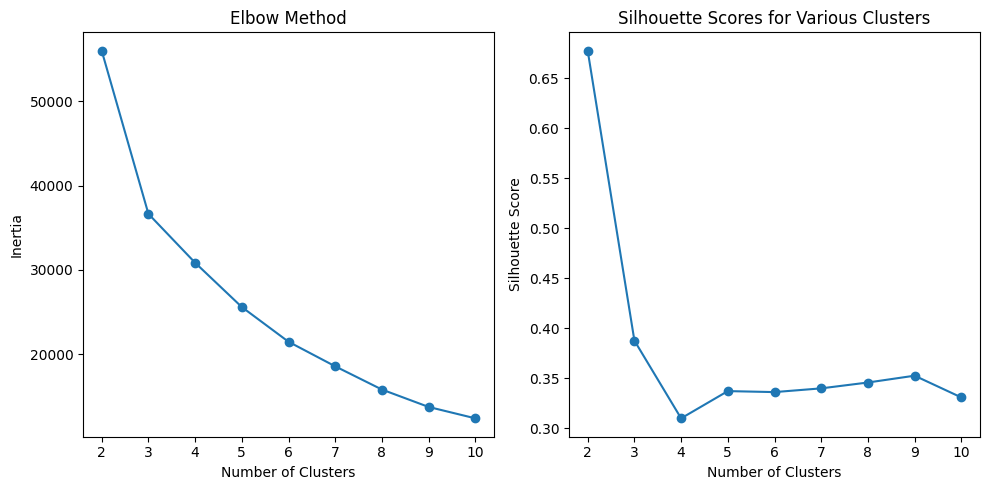

c:\Users\Tom Wu\Downloads\IFEEMCS520100\Car following project\car-following-project\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


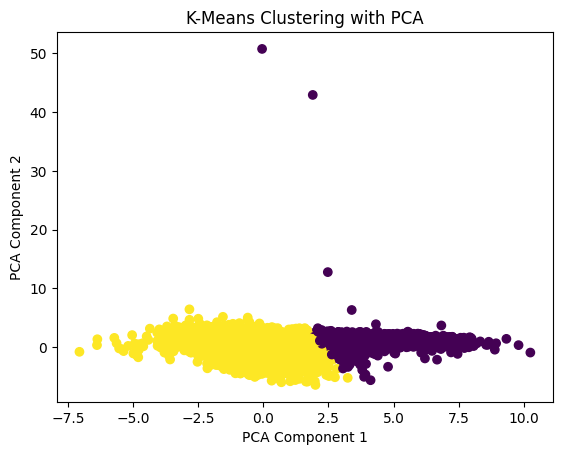

The average silhouette_score is: 0.6774392930539449
   delta_position  delta_velocity  v_follower  cluster
0        9.428864       -1.845334    0.784441      1.0
1        9.604988       -1.855325    0.810204      1.0
2        9.800511       -1.948792    0.828016      1.0
3        9.935984       -2.076852    0.889182      1.0
4       10.080130       -2.189449    0.979196      1.0
       delta_position  delta_velocity    v_follower       cluster
count    7.124118e+06    7.124118e+06  7.124118e+06  7.101892e+06
mean     1.801222e+01    1.024876e-01  8.903949e+00  9.525315e-01
std      9.535399e+00    1.259711e+00  4.674579e+00  2.126387e-01
min      3.192059e+00   -1.374209e+01 -5.396548e-01  0.000000e+00
25%      1.193010e+01   -4.169156e-01  6.416994e+00  1.000000e+00
50%      1.666871e+01    8.382282e-03  1.045558e+01  1.000000e+00
75%      2.163510e+01    6.671588e-01  1.282486e+01  1.000000e+00
max      8.521140e+01    1.542209e+01  2.060256e+01  1.000000e+00
cluster is over


Training Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch 0 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 1 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 2 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 3 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 4 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 5 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 6 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 7 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 8 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 9 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 10 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3]

Training Epochs: 100%|██████████| 1/1 [37:03<00:00, 2223.54s/it]


Epoch: 0 Loss: 0.0094
Train is over


Training Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch 0 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 1 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 2 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 3 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 4 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 5 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 6 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 7 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 8 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 9 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3])
Batch 10 - X_batch shape: torch.Size([256, 30, 3]), y_batch shape: torch.Size([256, 10, 3]

Training Epochs: 100%|██████████| 1/1 [01:25<00:00, 85.97s/it]

Epoch: 0 Loss: 0.0519
Train is over
Cluster nan is empty.


In [43]:
# set the dataset and mode
if __name__ == "__main__":
    dataset = "HA"
    train_mode = "train"
    eval_mode = "val"


    trainHA = convert_df(dataset, train_mode)
    clustered_data = get_clustered_df(trainHA)
    train_data = train_df(dataset, clustered_data, train_mode)
    print(train_data.describe())
    # train_data = train_data.sample(frac=0.01, random_state=1)
    models_scalers = run_training(train_data,dataset=dataset)



In [45]:
if __name__ == "__main__":    
    
    mode_name = "src/HAmodel_scaler_cluster_0.0.pth"
    eval_df = evaluate_df(dataset, eval_mode)
    eval_df = eval_df.head(40)
    delta_velocity_pred = predict_delta_velocity(eval_df, mode_name)
    print(f"Predicted result:", delta_velocity_pred)

   delta_position  delta_velocity  v_follower
0       25.147708        1.614755   11.265286
1       24.986054        1.589909   11.227821
2       24.847105        1.589107   11.216660
3       24.691872        1.587685   11.199787
4       24.533773        1.591374   11.174766
X_new_tensor torch.Size([5, 30, 3])
(5, 10, 3)
Predicted result: [0.01218921 0.21549919 0.26703417 0.27752933 0.269253   0.2549773
 0.24385755 0.24002552 0.23344105 0.21266915]


In [ ]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, check the CUDA version and cuDNN availability
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    cudnn_available = torch.backends.cudnn.is_available()
    print(f"cuDNN available: {cudnn_available}")

    # Print the version of cuDNN
    if cudnn_available:
        print(f"cuDNN version: {torch.backends.cudnn.version()}")
else:
    print("CUDA is not available. Please ensure that you have a CUDA-capable GPU and the necessary CUDA drivers installed.")


CUDA available: True
CUDA version: 11.8
cuDNN available: True
cuDNN version: 8700
